# Incremental capacity analysis (dQ/dV)
In this notebook we illustrate, how to use cellpy to extract dQ/dV data for selected cycles.

The respective methods are collected in the ica utilities (cellpy.utils.ica):

- **`ica.dqdv`**: This is the main and recommended method, taking data contained within the CellpyCell object as input.

- Additional methods allow for the calculation of dQ/dV data based on voltage and capacity data provided in different, cellpy-agnostic formats:
    - `ica.dqdv_cycle` and `ica.dqdv_cycles` takes Pandas DataFrames containing capacity vs voltage data for one or multiple cycles as input
    - `ica.dqdv_np` uses simple arrays or Pandas DataSeries of capacity and voltage as input.
    
For more details on these, have a look at the source code.

In [1]:
import cellpy
from cellpy.utils import example_data, ica

<div class="alert alert-block alert-info">
<b>Tip:</b> The plots in this notebook are based on <code>plotly</code>. If you have not installed plotly, you can do so by running <code>pip install plotly</code>. Alternatively, you can of course also use standard plotting tools such as <code>matplotlib</code> to plot the data from the obtained pandas DataFrames.</div>

In [2]:
import plotly.express as px

In [3]:
# Comment out this when running the notebook locally to get interactive plots
import plotly.io as pio
pio.renderers.default = "png"

Load an example datafile:

In [4]:
c = example_data.cellpy_file()

## Extracting dQ/dV data using `ica.dqdv`
This example shows how to get dQ/dV data directly and easily from the CellpyCell object (obtained by loading the data using `cellpy.get()`).

The dQ/dV data is provided as a Pandas DataFrame.

Without specifying any further options, the dQ/dV for all cycles contained within the CellpyCell is calculated:

In [5]:
ica_df = ica.dqdv(c)
ica_df.head()

,cycle,voltage,dq
0,1,0.051583,-6388.687162
1,1,0.054792,-6828.975477
2,1,0.058001,-7514.790533
3,1,0.061210,-8284.857174
4,1,0.064420,-9098.355196


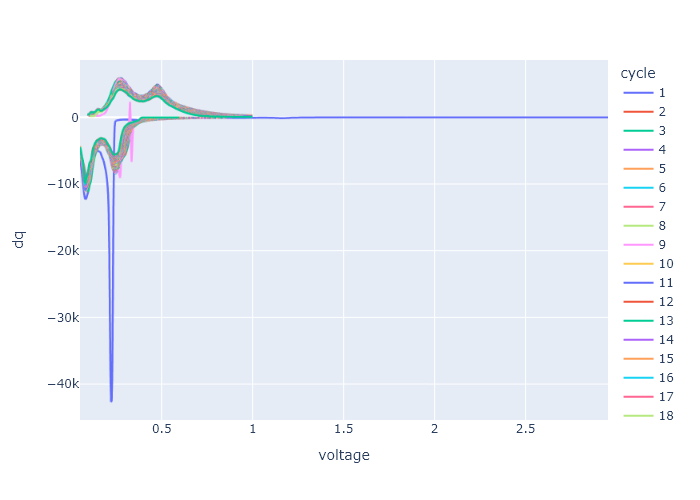

In [6]:
px.line(ica_df, x="voltage", y="dq", color="cycle")

If cycle number(s) are specified using the `cycle` keyword (as an integer or list of integers), the dQ/dV will be calculated for those cycles only. If `split=True`, two separate Pandas Dataframes will be obtained, one containing charge, and one containing discharge data:

In [7]:
cycles=[2, 3, 4]
charge_ica, discharge_ica = ica.dqdv(c, split=True, cycle=cycles)

In [8]:
charge_ica.head(3)

,voltage,cycle,dq
0,0.094257,2,NaN
1,0.103407,2,365.946074
2,0.112558,2,598.189449


In [9]:
discharge_ica.head(3)

,voltage,cycle,dq
0,0.049979,2,NaN
1,0.058489,2,-6538.113356
2,0.066999,2,-7797.598247


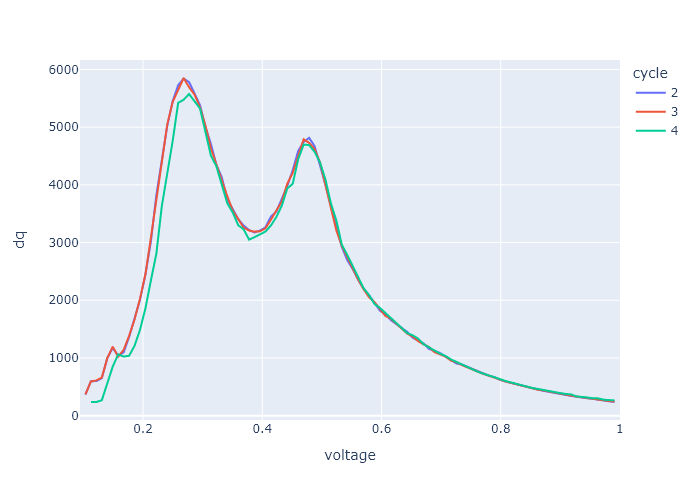

In [10]:
px.line(charge_ica, x="voltage", y="dq", color="cycle")

### Tweaking the algorithm

In [11]:
ica_df_1 = ica.dqdv(c, cycle=3, voltage_resolution=0.03)
ica_df_2 = ica.dqdv(c, cycle=3, voltage_resolution=0.01)
ica_df_3 = ica.dqdv(c, cycle=3, voltage_resolution=0.005)

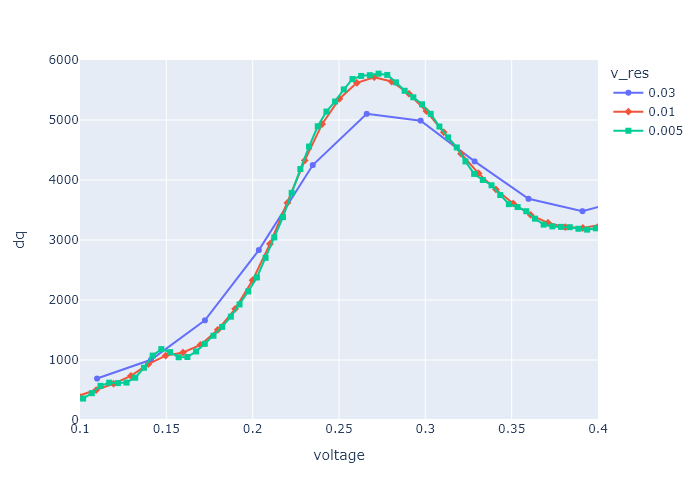

In [12]:
import pandas as pd
ica_both = pd.concat([ica_df_1, ica_df_2, ica_df_3], keys=["0.03", "0.01", "0.005"], names=["v_res", "index"]).reset_index()
px.line(ica_both, x="voltage", y="dq", color="v_res", range_x=[0.1, 0.4], range_y=[0, 6000], symbol="v_res")

### More details on dqdv
A lot of different options with respect to smoothing, interpolation etc. are available when calculating the dQ/dV. For more details, have a look at the source code:

```python
def dqdv(cell, split=False, tidy=True, label_direction=False, **kwargs):
    """Calculates dq-dv data for all cycles contained in
    the given CellpyCell object, returns data as pandas.DataFrame(s) 

    Args:
        cell (CellpyCell-object).
        split (bool): return one frame for charge and one for
            discharge if True (defaults to False).
        tidy (bool): returns the split frames in wide format (defaults
            to True. Remark that this option is currently not available
            for non-split frames).

    Returns:
        one or two ``pandas.DataFrame`` with the following columns:
        cycle: cycle number (if split is set to True).
        voltage: voltage
        dq: the incremental capacity


    Additional key-word arguments are sent to Converter:

    Keyword Args:
        cycle (int or list of ints (cycle numbers)): will process all (or up to max_cycle_number)
            if not given or equal to None.
        points_pr_split (int): only used when investigating data
            using splits, defaults to 10.
        max_points: None
        voltage_resolution (float): used for interpolating voltage
            data (e.g. 0.005)
        capacity_resolution: used for interpolating capacity data
        minimum_splits (int): defaults to 3.
        interpolation_method: scipy interpolation method
        increment_method (str): defaults to "diff"
        pre_smoothing (bool): set to True for pre-smoothing (window)
        smoothing (bool): set to True for smoothing during
            differentiation (window)
        post_smoothing (bool): set to True for post-smoothing
            (gaussian)
        normalize (bool): set to True for normalizing to capacity
        normalizing_factor (float):
        normalizing_roof  (float):
        savgol_filter_window_divisor_default (int): used for window
            smoothing, defaults to 50
        savgol_filter_window_order: used for window smoothing
        voltage_fwhm (float): used for setting the post-processing
            gaussian sigma, defaults to 0.01
        gaussian_order (int): defaults to 0
        gaussian_mode (str): defaults to "reflect"
        gaussian_cval (float): defaults to 0.0
        gaussian_truncate (float): defaults to 4.0

    Example:
        >>> from cellpy.utils import ica
        >>> charge_df, dcharge_df = ica.dqdv(my_cell, split=True)
        >>> charge_df.plot(x="voltage",y="dq")
```

## Using the cellpy-agnostic methods
- `ica.dqdv_cycle` and `ica.dqdv_cycles` takes Pandas DataFrames containing capacity vs voltage data for one or multiple cycles as input
- `ica.dqdv_np` uses simple arrays or Pandas DataSeries of capacity and voltage as input.


To use the cellpy-agnostic methods mentioned above, capacity vs voltage data is needed as input. This has to be extracted first and can be done, e.g., by using the `get_cap` method.

Specify cycle number(s):

In [13]:
cycle=2
cycles=[2, 3, 4]

Get capacities (note here that the dqdv methods require `categorical_column` and `label_cycle_number` to be set to `True`):

In [14]:
vcap = c.get_cap(cycle=cycle, categorical_column=True, method="forth-and-forth", insert_nan=False, label_cycle_number=True)
vcap.head(2)

,cycle,voltage,capacity,direction
1525,2,0.892503,0.041180,-1
1526,2,0.887276,0.176045,-1


`dqdv_cycle` then outputs a tuple containing voltage and incremental capacity:

In [15]:
voltage, capacity = ica.dqdv_cycle(vcap)
print(f"voltage:\n{voltage[:10]}\n\ncapacity:\n{capacity[:10]}")

voltage:
[0.05087869 0.05267896 0.05447923 0.05627949 0.05807976 0.05988003
 0.06168029 0.06348056 0.06528083 0.06708109]

capacity:
[-5707.83447516 -5816.23674218 -6004.10155608 -6234.12949797
 -6480.74747702 -6733.15734537 -6987.70817472 -7244.6875613
 -7512.44888318 -7811.17678808]


while `dqdv_cycles` returns a pandas DataFrame:

In [16]:
ica_cycles = ica.dqdv_cycles(vcap)
ica_cycles.head()

,cycle,voltage,dq
0,2,0.050879,-5707.834475
1,2,0.052679,-5816.236742
2,2,0.054479,-6004.101556
3,2,0.056279,-6234.129498
4,2,0.058080,-6480.747477


Doing the same for multiple cycle numbers:

In [17]:
vcaps = c.get_cap(cycle=cycles, categorical_column=True, method="forth-and-forth", insert_nan=False, label_cycle_number=True)
ica_curves = ica.dqdv_cycles(vcaps)

In [18]:
ica_curves.head(2)

,cycle,voltage,dq
0,2,0.050879,-5707.834475
1,2,0.052679,-5816.236742
